# 0.1 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats import api as sms

In [2]:
df = pd.read_csv('ab_testing.csv')

In [3]:
df.head()

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
1,11122053,USA,M,498,2,2017-07-14,GRP B,I
2,11128688,USA,F,2394,6,2017-09-17,GRP A,I
3,11130578,USA,F,1197,3,2017-11-30,GRP A,I
4,11130759,ESP,M,1297,3,2018-01-10,GRP B,A


# 1.0 Planejamento

## 1.1 Design de Experimentos.

In [4]:
#Problema: Existe a forma de pagamento convencional e a empresea implementou uma nova foma de pagamento onde é possível realizar o preenchimento automático dos dados de cartão de crédito.

# Objetivo: Definir se os clientes gastam mais com preenchimento automático da página de checkout do que com o preenchimento manual.
# Métrica: GMV (Gross Margin Revenue) médio

# Group A = Preencimento automático
# Group B = Preenchimento manual

## 1.2 Formulação de Hipóteses

In [5]:
# H0: avg GMV A == avg GMV B 
# H0: avg GMV A <> avg GMV B

# 2.0 Testes

## 2.1 Geral

### 2.1.1 Parâmetros do Experimento

In [6]:
# nível de confiança
confidence = 0.95

# nível de significancia
significance = 0.05

# poder estatístico
power = 0.8

In [7]:
# valor de init_metric e std_mestric
df['spent'].agg(['mean', 'std'])

mean    1883.453349
std     1363.921546
Name: spent, dtype: float64

### 2.1.2 Tamanho da Amostra

In [8]:
init_metric = 1883.453349 #métrica atual grupo A
end_metric = init_metric * (1 + 0.05) #métrica a alcançar grupo B
std_metric = 1363.921546

effect_size =(end_metric - init_metric) / std_metric

sample_n = sms.tt_ind_solve_power(
                effect_size = effect_size, 
                alpha = significance, 
                power = power)
sample_n = np.round(sample_n).astype(int)

print(f'O tamanho total da amostra é de {2*sample_n}')
print(f'O tamanho da amostra do grupo de controle é de {sample_n}')
print(f'O tamanho da amostra do grupo de tratamento é de {sample_n}')

O tamanho total da amostra é de 6588
O tamanho da amostra do grupo de controle é de 3294
O tamanho da amostra do grupo de tratamento é de 3294


### 2.1.3 Análise descritiva dos dados

#### 2.1.3.1 Tamanho do dataset

In [9]:
print(f'Número de linhas: {df.shape[0]}')
print(f'Número de colunas: {df.shape[1]}')

Número de linhas: 45883
Número de colunas: 8


#### 2.1.3.2 Verificação de NA

In [10]:
df.isna().sum()

uid          0
country      0
gender       0
spent        0
purchases    0
date         0
group        0
device       0
dtype: int64

#### 2.1.3.3 Verificação da unidade experimental


In [11]:
df[['uid', 'group']].groupby('uid').count().reset_index().query( 'group > 1')

,uid,group


#### 2.1.3.4 Homogeinidade dos grupos

In [12]:
# gender
df[['uid', 'group', 'gender']].groupby(['group', 'gender']).count()

uid
group gender       
GRP A F       11371
      M       11638
GRP B F       11396
      M       11478

In [13]:
# device
df[['uid', 'group', 'device']].groupby(['group', 'device']).count()

uid
group device       
GRP A A       11487
      I       11522
GRP B A       11495
      I       11379

In [14]:
# country/spent/purchases
df.groupby('group').agg( {'country': 'count',
                           'spent': ['min', 'max', 'mean', 'std'],
                           'purchases': ['min', 'max', 'mean', 'std']

})

country spent                                  purchases                \
        count   min    max         mean          std       min max      mean   
group                                                                          
GRP A   23009    99  11176  1880.504281  1368.402763         1  25  4.536355   
GRP B   22874    99  12170  1886.419822  1359.422437         1  30  4.552461   

                 
            std  
group            
GRP A  3.110742  
GRP B  3.094142

##### 2.1.3.4.1 Homogeinidade geral entre os grupos

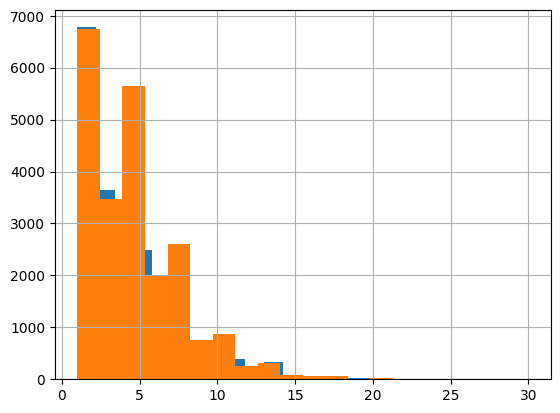

In [15]:
df.loc[df['group'] == 'GRP A', 'purchases'].hist(bins=20);
df.loc[df['group'] == 'GRP B', 'purchases'].hist(bins=20);

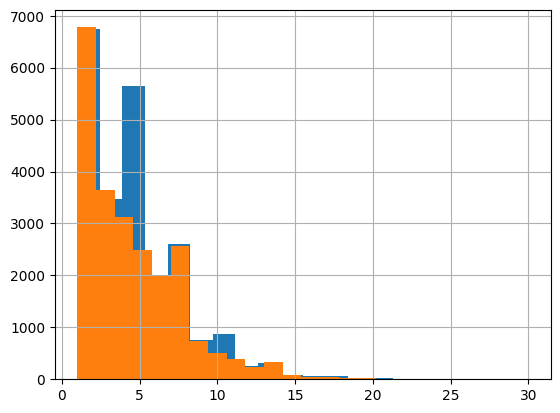

In [16]:
df.loc[df['group'] == 'GRP B', 'purchases'].hist(bins=20);
df.loc[df['group'] == 'GRP A', 'purchases'].hist(bins=20);

In [17]:
df[['uid', 'group']].groupby('group').count()

,uid
group,
GRP A,23009
GRP B,22874


<AxesSubplot:xlabel='device', ylabel='spent'>

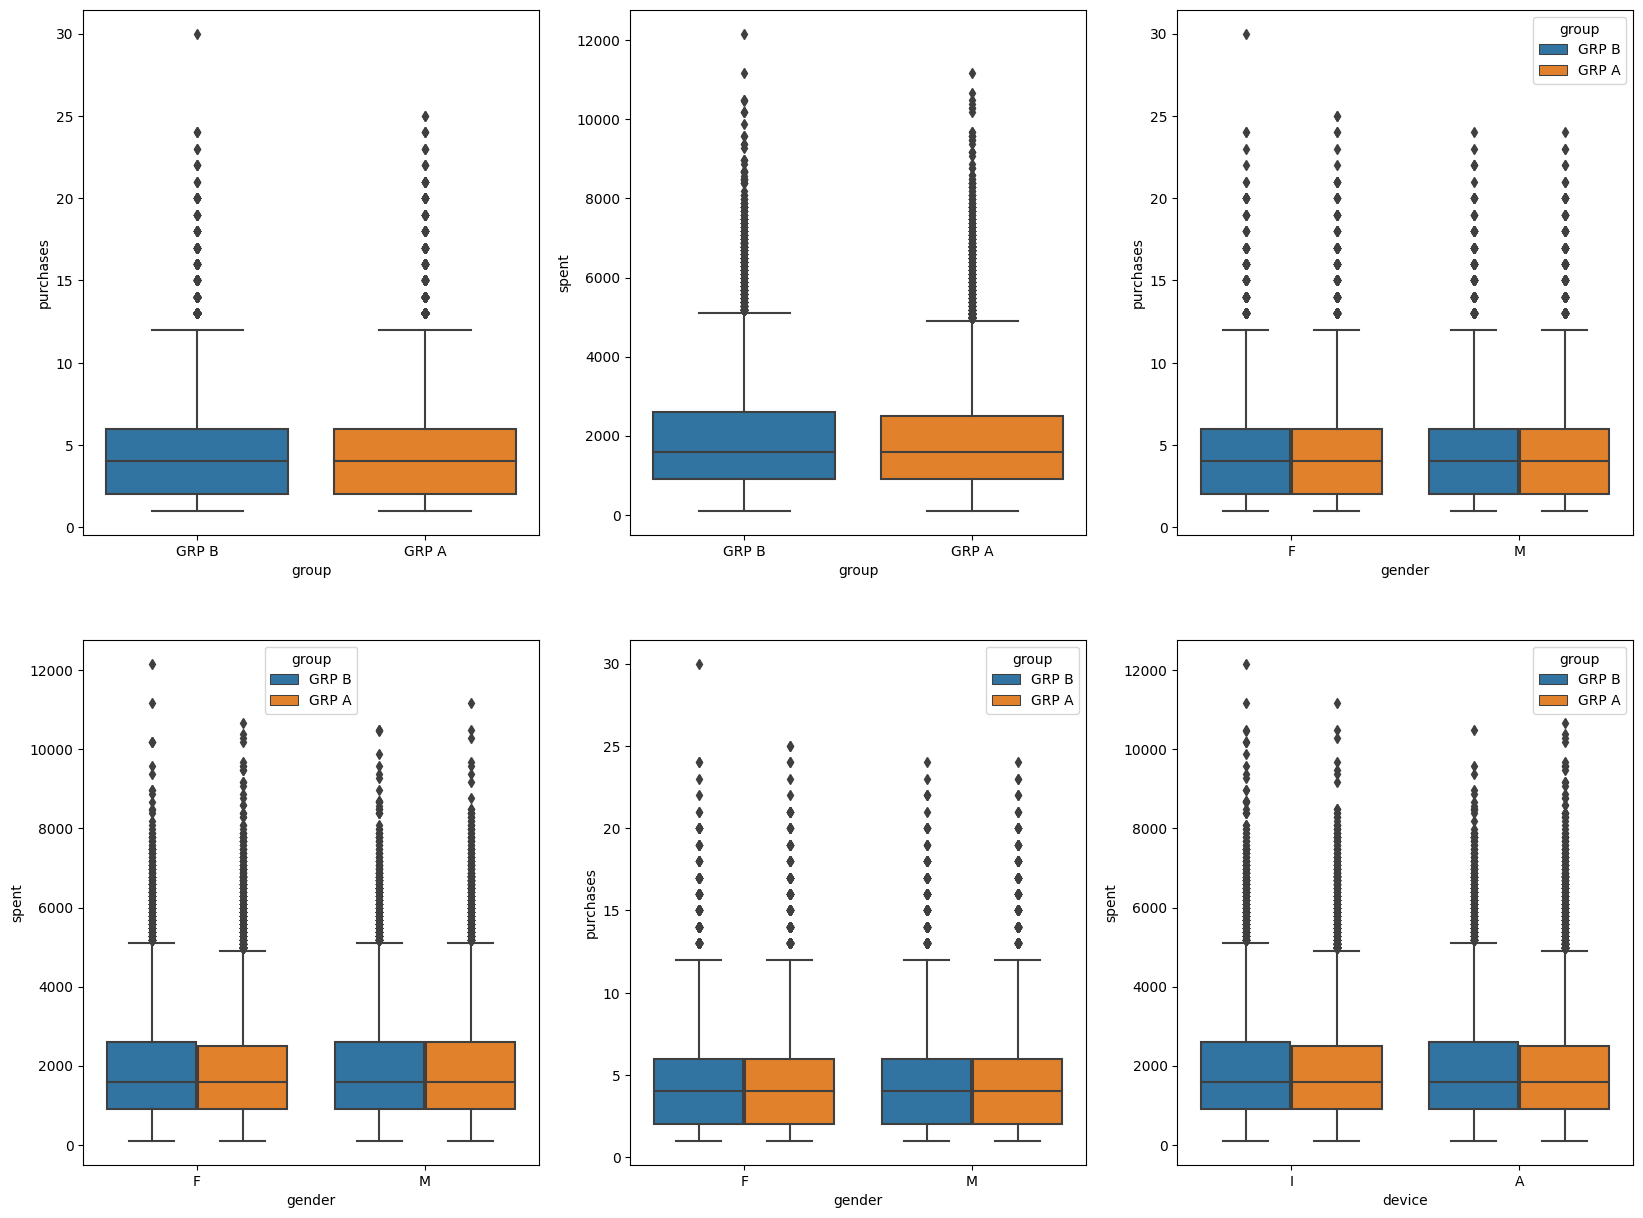

In [18]:
plt.figure(figsize=(20, 15))
plt.subplot(2,3,1)
sns.boxplot(x=df['group'], y=df['purchases'])
plt.subplot(2,3,2)
sns.boxplot(x=df['group'], y=df['spent'])
plt.subplot(2,3,3)
sns.boxplot(x=df['gender'], y=df['purchases'], hue=df['group'])
plt.subplot(2,3,4)
sns.boxplot(x=df['gender'], y=df['spent'], hue=df['group'])
plt.subplot(2,3,5)
sns.boxplot(x=df['gender'], y=df['purchases'], hue=df['group'])
plt.subplot(2,3,6)
sns.boxplot(x=df['device'], y=df['spent'], hue=df['group'])



<AxesSubplot:xlabel='country', ylabel='spent'>

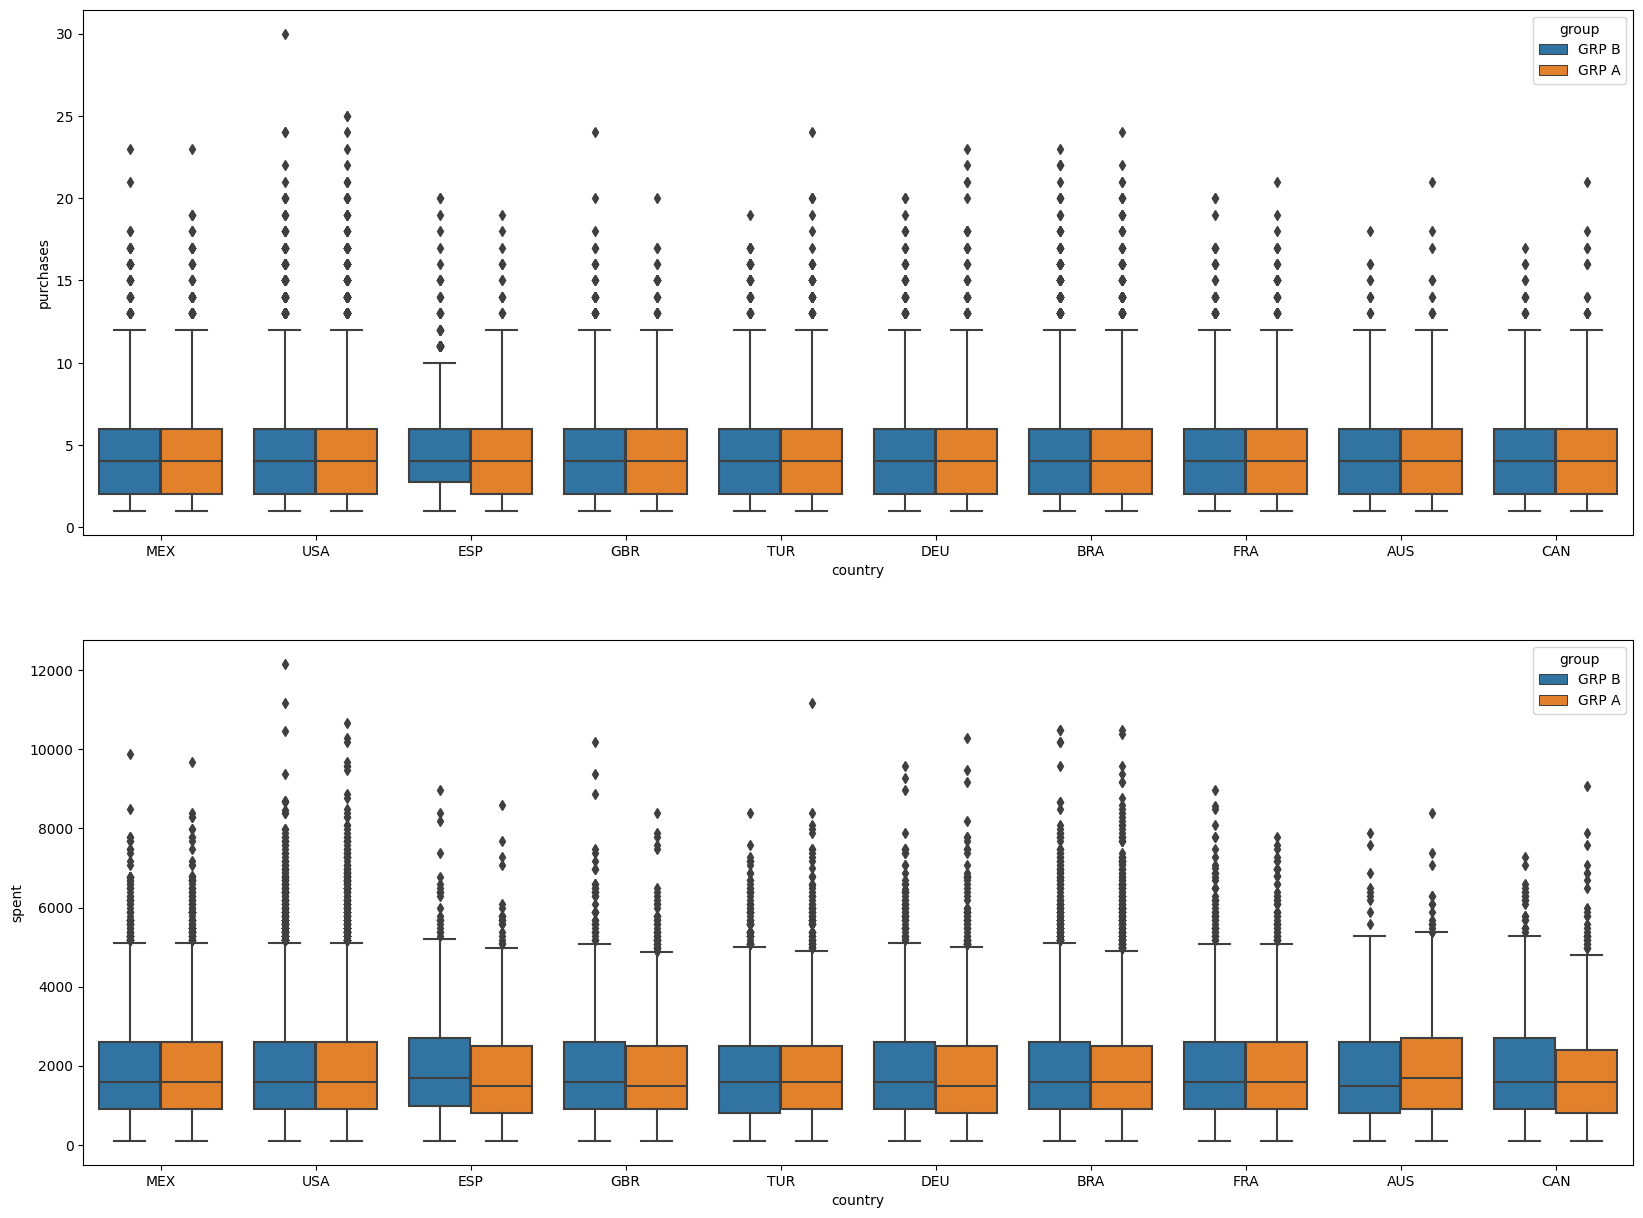

In [19]:
plt.figure(figsize=(20, 15))
plt.subplot(2,1,1)
sns.boxplot(x=df['country'], y=df['purchases'], hue=df['group'])
plt.subplot(2,1,2)
sns.boxplot(x=df['country'], y=df['spent'], hue=df['group'])

### 2.1.4 Teste de hipóteses

#### 2.1.4.1 Grupos

In [20]:
sample_A = df.loc[df['group'] == 'GRP A', 'spent'].sample(n=sample_n, random_state = 42)
sample_B = df.loc[df['group'] == 'GRP B', 'spent'].sample(n=sample_n, random_state = 42)

#### 2.1.4.2 Métricas

In [21]:
sample_A_mean = np.round(sample_A.mean(), 2)
sample_A_std = np.round(sample_A.std(), 2)
sample_B_mean = np.round(sample_B.mean(), 2)
sample_B_std = np.round(sample_B.std(), 2)

print(f'Média da amostra do grupo A: {sample_A_mean} +/- {sample_A_std}')
print(f'Média da amostra do grupo B: {sample_B_mean} +/- {sample_B_std}')

Média da amostra do grupo A: 1878.01 +/- 1346.7
Média da amostra do grupo B: 1899.16 +/- 1348.41


### 2.1.5 Inferência Estatística

In [22]:
t_test, p_value = stats.ttest_ind( sample_A, sample_B)
print(p_value)

0.5240747499077292


### 2.1.6 Conclusão

In [23]:
if p_value < significance:
    print('Rejeita a hipótese nula: O preenchimento automático deu resultado')
else:
    print('Falha em rejeitar a hipótese nula: Não temos evidências para dizer que o preenchimento automático trouxe mudança')

Falha em rejeitar a hipótese nula: Não temos evidências para dizer que o preenchimento automático trouxe mudança


## 2.2 Brasil

In [24]:
df_bra = df.loc[df['country'] == 'BRA', :]
df_bra.head()

,uid,country,gender,spent,purchases,date,group,device
12,11143138,BRA,M,2592,8,2015-05-20,GRP B,A
15,11148343,BRA,M,299,1,2016-09-04,GRP B,A
31,11172970,BRA,M,1797,3,2017-07-05,GRP B,I
36,11177332,BRA,M,1994,6,2017-01-06,GRP B,I
37,11179295,BRA,M,1198,2,2017-12-19,GRP B,A


### 2.2.1 Parâmetros do Experimento

In [25]:
# nível de confiança
confidence_bra = 0.97

# nível de significancia
significance_bra = 0.03

# poder estatístico
power_bra = 0.8

In [26]:
# valor de init_metric e std_mestric
df_bra['spent'].agg(['mean', 'std'])

mean    1902.860251
std     1398.886279
Name: spent, dtype: float64

### 2.2.2 Tamanho da Amostra

In [27]:
init_metric_bra = 1902.860251 #métrica atual grupo A
end_metric_bra = init_metric_bra * (1 + 0.05) #métrica a alcançar grupo B
std_metric_bra = 1398.886279

effect_size_bra =(end_metric_bra - init_metric_bra ) / std_metric_bra

sample_n_bra = sms.tt_ind_solve_power(
                effect_size = effect_size_bra, 
                alpha = significance_bra, 
                power = power_bra)
sample_n_bra = np.round(sample_n_bra).astype(int)

print(f'O tamanho total da amostra é de {2*sample_n_bra}')
print(f'O tamanho da amostra do grupo de controle é de {sample_n_bra}')
print(f'O tamanho da amostra do grupo de tratamento é de {sample_n_bra}')

O tamanho total da amostra é de 7846
O tamanho da amostra do grupo de controle é de 3923
O tamanho da amostra do grupo de tratamento é de 3923


### 2.2.3 Análise descritiva dos dados

#### 2.2.3.1 Tamanho do dataset

In [28]:
print(f'Número de colunas: {df_bra.shape[1]}')
print(f'Número de linhas: {df_bra.shape[0]}')

Número de colunas: 8
Número de linhas: 9009


#### 2.2.3.2 Homogeinidade dos grupos

In [29]:
# gender
df_bra[['uid', 'group', 'gender']].groupby(['group', 'gender']).count()

uid
group gender      
GRP A F       2213
      M       2305
GRP B F       2208
      M       2283

In [30]:
# device
df_bra[['uid', 'group', 'device']].groupby(['group', 'device']).count()

uid
group device      
GRP A A       2208
      I       2310
GRP B A       2284
      I       2207

In [31]:
# country/spent/purchases
df_bra.groupby('group').agg( {'country': 'count',
                           'spent': ['min', 'max', 'mean', 'std'],
                           'purchases': ['min', 'max', 'mean', 'std']

})

country spent                                  purchases                \
        count   min    max         mean          std       min max      mean   
group                                                                          
GRP A    4518    99  10480  1899.792165  1413.074052         1  24  4.568172   
GRP B    4491    99  10478  1905.946782  1384.617019         1  23  4.585393   

                 
            std  
group            
GRP A  3.170057  
GRP B  3.132202

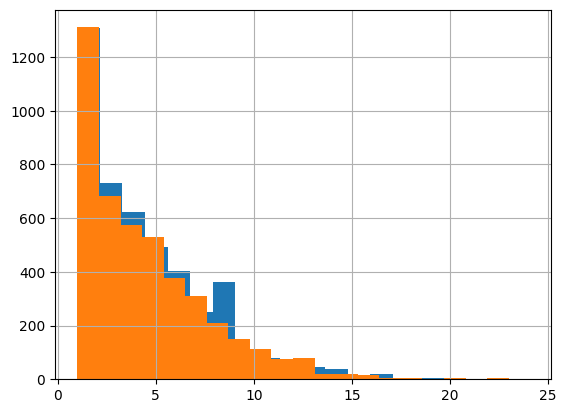

In [32]:
# homogeinidade geral dos grupos
df_bra.loc[df_bra['group'] == 'GRP A', 'purchases'].hist(bins=20);
df_bra.loc[df_bra['group'] == 'GRP B', 'purchases'].hist(bins=20);

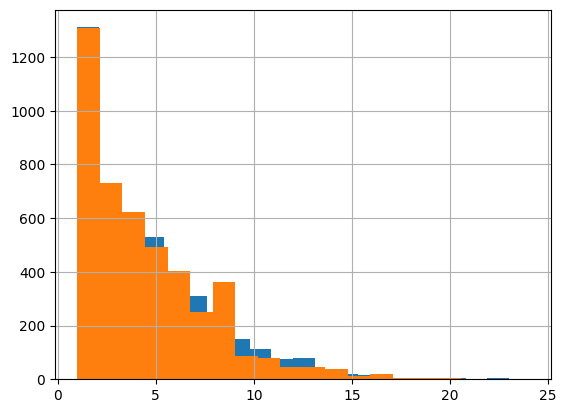

In [33]:
df_bra.loc[df_bra['group'] == 'GRP B', 'purchases'].hist(bins=20);
df_bra.loc[df_bra['group'] == 'GRP A', 'purchases'].hist(bins=20);

In [34]:
df_bra[['uid', 'group']].groupby('group').count()

,uid
group,
GRP A,4518
GRP B,4491


### 2.2.4 Teste de hipóteses

#### 2.2.4.1 Grupos

In [35]:
sample_A_bra = df_bra.loc[df_bra['group'] == 'GRP A', 'spent'].sample(n=sample_n_bra, random_state = 42)
sample_B_bra = df_bra.loc[df_bra['group'] == 'GRP B', 'spent'].sample(n=sample_n_bra, random_state = 42)

#### 2.2.4.1 Métricas

In [36]:
sample_A_bra_mean = np.round(sample_A_bra.mean(), 2)
sample_A_bra_std = np.round(sample_A_bra.std(), 2)
sample_B_bra_mean = np.round(sample_B_bra.mean(), 2)
sample_B_bra_std = np.round(sample_B_bra.std(), 2)

print(f'Média da amostra do grupo A: {sample_A_bra_mean} +/- {sample_A_bra_std}')
print(f'Média da amostra do grupo A: {sample_B_bra_mean} +/- {sample_B_bra_std}')

Média da amostra do grupo A: 1900.68 +/- 1405.98
Média da amostra do grupo A: 1903.85 +/- 1387.21


### 2.2.5 Inferência Estatística

In [37]:
t_test_bra, p_value_bra = stats.ttest_ind( sample_A_bra, sample_B_bra)
print(p_value_bra)

0.9198913157613525


### 2.2.6 Conclusão

In [38]:
if p_value_bra < significance_bra:
    print('Rejeita a hipótese nula: O preenchimento automático deu resultado')
else:
    print('Falha em rejeitar a hipótese nula: Não temos evidências para dizer que o preenchimento automático trouxe mudança')


Falha em rejeitar a hipótese nula: Não temos evidências para dizer que o preenchimento automático trouxe mudança


## 2.3 México

In [39]:
df_mex = df.loc[df['country'] == 'MEX', :]
df_mex.head()

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
13,11146038,MEX,M,1795,5,2016-01-05,GRP A,A
18,11154067,MEX,F,1096,4,2017-08-03,GRP A,A
33,11174686,MEX,F,3293,7,2017-10-02,GRP A,I
67,11229291,MEX,M,1198,2,2016-12-23,GRP B,I


### 2.3.1 Parâmetros do Experimento

In [40]:
# nível de confiança
confidence_mex = 0.90

# nível de significancia
significance_mex = 0.1

# poder estatístico
power_mex = 0.80

In [41]:
# valor de init_metric e std_mestric
df_mex['spent'].agg(['mean', 'std'])

mean    1893.150507
std     1355.476662
Name: spent, dtype: float64

### 2.3.2 Tamanho da Amostra

In [42]:
init_metric_mex = 1893.150507 #métrica atual grupo A
end_metric_mex = init_metric_mex * (1 + 0.05) #métrica a alcançar grupo B
std_metric_mex = 1355.476662

effect_size_mex =(end_metric_mex - init_metric_mex) / std_metric_mex

sample_n_mex = sms.tt_ind_solve_power(
                effect_size = effect_size_mex, 
                alpha = significance_mex, 
                power = power_mex)
sample_n_mex = np.round(sample_n_mex).astype(int)

print(f'O tamanho total da amostra é de {2*sample_n_mex}')
print(f'O tamanho da amostra do grupo de controle é de {sample_n_mex}')
print(f'O tamanho da amostra do grupo de tratamento é de {sample_n_mex}')

O tamanho total da amostra é de 5072
O tamanho da amostra do grupo de controle é de 2536
O tamanho da amostra do grupo de tratamento é de 2536


### 2.3.3 Análise descritiva dos dados

#### 2.3.3.1 Tamanho do dataset

In [43]:
print(f'Número de colunas: {df_mex.shape[1]}')
print(f'Número de linhas: {df_mex.shape[0]}')

Número de colunas: 8
Número de linhas: 5528


#### 2.3.3.2 Homogeinidade dos grupos

In [44]:
# gender
df_mex[['uid', 'group', 'gender']].groupby(['group', 'gender']).count()

uid
group gender      
GRP A F       1404
      M       1482
GRP B F       1318
      M       1324

In [45]:
# device
df_mex[['uid', 'group', 'device']].groupby(['group', 'device']).count()

uid
group device      
GRP A A       1451
      I       1435
GRP B A       1287
      I       1355

In [46]:
# country/spent/purchases
df_mex.groupby('group').agg( {'country': 'count',
                           'spent': ['min', 'max', 'mean', 'std'],
                           'purchases': ['min', 'max', 'mean', 'std']

})

country spent                                 purchases                \
        count   min   max         mean          std       min max      mean   
group                                                                         
GRP A    2886    99  9677  1902.705821  1361.369586         1  23  4.570686   
GRP B    2642    99  9877  1882.712718  1349.190339         1  23  4.531794   

                 
            std  
group            
GRP A  3.085218  
GRP B  3.057435

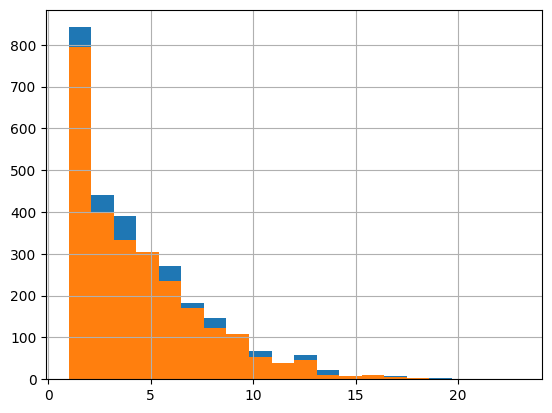

In [47]:
# homogeinidade geral dos grupos
df_mex.loc[df_mex['group'] == 'GRP A', 'purchases'].hist(bins=20);
df_mex.loc[df_mex['group'] == 'GRP B', 'purchases'].hist(bins=20);

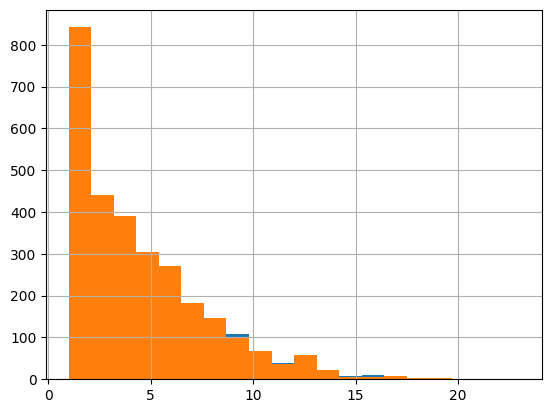

In [48]:
df_mex.loc[df_mex['group'] == 'GRP B', 'purchases'].hist(bins=20);
df_mex.loc[df_mex['group'] == 'GRP A', 'purchases'].hist(bins=20);

In [49]:
df_mex[['uid', 'group']].groupby('group').count()

,uid
group,
GRP A,2886
GRP B,2642


### 2.3.4 Teste de hipóteses

#### 2.3.4.1 Grupos

In [50]:
sample_A_mex = df_mex.loc[df_mex['group'] == 'GRP A', 'spent'].sample(n=sample_n_mex, random_state = 42)
sample_B_mex = df_mex.loc[df_mex['group'] == 'GRP B', 'spent'].sample(n=sample_n_mex, random_state = 42)

#### 2.3.4.1 Métricas

In [51]:
sample_A_mex_mean = np.round(sample_A_mex.mean(), 2)
sample_A_mex_std = np.round(sample_A_mex.std(), 2)
sample_B_mex_mean = np.round(sample_B_mex.mean(), 2)
sample_B_mex_std = np.round(sample_B_mex.std(), 2)

print(f'Média da amostra do grupo A: {sample_A_mex_mean} +/- {sample_A_mex_std}')
print(f'Média da amostra do grupo A: {sample_B_mex_mean} +/- {sample_B_mex_std}')

Média da amostra do grupo A: 1902.6 +/- 1375.83
Média da amostra do grupo A: 1878.88 +/- 1358.2


### 2.3.5 Inferência Estatística

In [52]:
t_test_mex, p_value_mex = stats.ttest_ind( sample_A_mex, sample_B_mex)
print(p_value_mex)

0.5365311538406528


### 2.3.6 Conclusão

In [53]:
if p_value_mex < significance_mex:
    print('Rejeita a hipótese nula: O preenchimento automático deu resultado')
else:
    print('Falha em rejeitar a hipótese nula: Não temos evidências para dizer que o preenchimento automático trouxe mudança')


Falha em rejeitar a hipótese nula: Não temos evidências para dizer que o preenchimento automático trouxe mudança


## 2.4 USA 

In [54]:
df_usa = df.loc[df['country'] == 'USA', :]
df_usa.head()

,uid,country,gender,spent,purchases,date,group,device
1,11122053,USA,M,498,2,2017-07-14,GRP B,I
2,11128688,USA,F,2394,6,2017-09-17,GRP A,I
3,11130578,USA,F,1197,3,2017-11-30,GRP A,I
5,11131070,USA,M,1796,4,2016-08-08,GRP B,I
8,11132813,USA,M,698,2,2017-07-27,GRP A,I


### 2.4.1 Parâmetros do Experimento

In [55]:
# nível de confiança
confidence_usa = 0.99

# nível de significancia
significance_usa = 0.01

# poder estatístico
power_usa = 0.8

In [56]:
# valor de init_metric e std_mestric
df_usa['spent'].agg(['mean', 'std'])

mean    1876.435491
std     1358.231569
Name: spent, dtype: float64

### 2.4.2 Tamanho da Amostra

In [57]:
init_metric_usa = 1876.435491 #métrica atual grupo A
end_metric_usa = init_metric_usa * (1 + 0.05) #métrica a alcançar grupo B
std_metric_usa = 1358.231569

effect_size_usa = (end_metric_usa - init_metric_usa) / std_metric_usa

sample_n_usa = sms.tt_ind_solve_power(
                effect_size = effect_size_usa, 
                alpha = significance_usa, 
                power = power_usa)
sample_n_usa = np.round(sample_n_usa).astype(int)

print(f'O tamanho total da amostra é de {2*sample_n_usa}')
print(f'O tamanho da amostra do grupo de controle é de {sample_n_usa}')
print(f'O tamanho da amostra do grupo de tratamento é de {sample_n_usa}')

O tamanho total da amostra é de 9794
O tamanho da amostra do grupo de controle é de 4897
O tamanho da amostra do grupo de tratamento é de 4897


### 2.4.3 Análise descritiva dos dados

#### 2.4.3.1 Tamanho do dataset

In [58]:
print(f'Número de colunas: {df_usa.shape[1]}')
print(f'Número de linhas: {df_usa.shape[0]}')

Número de colunas: 8
Número de linhas: 13998


#### 2.4.3.2 Homogeinidade dos grupos

In [59]:
# gender
df_usa[['uid', 'group', 'gender']].groupby(['group', 'gender']).count()

uid
group gender      
GRP A F       3441
      M       3486
GRP B F       3477
      M       3594

In [60]:
# device
df_usa[['uid', 'group', 'device']].groupby(['group', 'device']).count()

uid
group device      
GRP A A       3501
      I       3426
GRP B A       3540
      I       3531

In [61]:
# country/spent/purchases
df_usa.groupby('group').agg( {'country': 'count',
                           'spent': ['min', 'max', 'mean', 'std'],
                           'purchases': ['min', 'max', 'mean', 'std']

})

country spent                                  purchases                \
        count   min    max         mean          std       min max      mean   
group                                                                          
GRP A    6927    99  10675  1888.376065  1367.939102         1  25  4.564602   
GRP B    7071    99  12170  1864.738085  1348.648216         1  30  4.502475   

                 
            std  
group            
GRP A  3.112318  
GRP B  3.079928

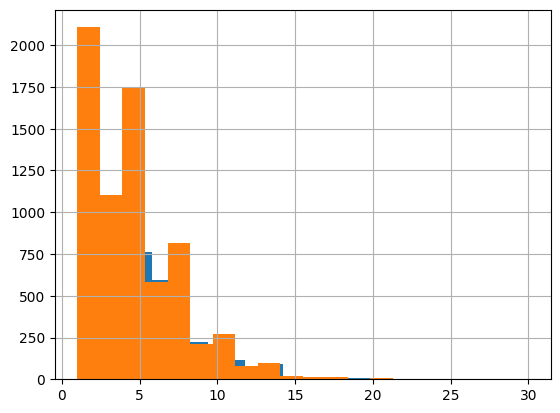

In [62]:
# homogeinidade geral dos grupos
df_usa.loc[df_usa['group'] == 'GRP A', 'purchases'].hist(bins=20);
df_usa.loc[df_usa['group'] == 'GRP B', 'purchases'].hist(bins=20);

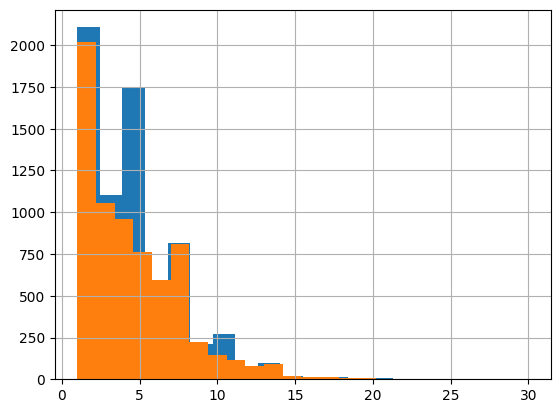

In [63]:
df_usa.loc[df_usa['group'] == 'GRP B', 'purchases'].hist(bins=20);
df_usa.loc[df_usa['group'] == 'GRP A', 'purchases'].hist(bins=20);

In [64]:
df_usa[['uid', 'group']].groupby('group').count()

,uid
group,
GRP A,6927
GRP B,7071


### 2.4.4 Teste de hipóteses

#### 2.4.4.1 Grupos

In [65]:
sample_A_usa = df_usa.loc[df_usa['group'] == 'GRP A', 'spent'].sample(n=sample_n_usa, random_state = 42)
sample_B_usa = df_usa.loc[df_usa['group'] == 'GRP B', 'spent'].sample(n=sample_n_usa, random_state = 42)

#### 2.4.4.1 Métricas

In [66]:
sample_A_usa_mean = np.round(sample_A_usa.mean(), 2)
sample_A_usa_std = np.round(sample_A_usa.std(), 2)
sample_B_usa_mean = np.round(sample_B_usa.mean(), 2)
sample_B_usa_std = np.round(sample_B_usa.std(), 2)

print(f'Média da amostra do grupo A: {sample_A_usa_mean} +/- {sample_A_usa_std}')
print(f'Média da amostra do grupo A: {sample_B_usa_mean} +/- {sample_B_usa_std}')

Média da amostra do grupo A: 1889.51 +/- 1375.28
Média da amostra do grupo A: 1860.95 +/- 1361.11


### 2.4.5 Inferência Estatística

In [67]:
t_test_usa, p_value_usa = stats.ttest_ind( sample_A_usa, sample_B_usa)
print(p_value_usa)

0.3016930721958253


### 2.4.5 Conclusão

In [68]:
if p_value_usa < significance_usa:
    print('Rejeita a hipótese nula: O preenchimento automático deu resultado')
else:
    print('Falha em rejeitar a hipótese nula: Não temos evidências para dizer que o preenchimento automático trouxe mudança')


Falha em rejeitar a hipótese nula: Não temos evidências para dizer que o preenchimento automático trouxe mudança


## 2.5 Espanha

In [69]:
df_esp = df.loc[df['country'] == 'ESP', :]
df_esp.head()

,uid,country,gender,spent,purchases,date,group,device
4,11130759,ESP,M,1297,3,2018-01-10,GRP B,A
17,11149952,ESP,M,398,2,2017-02-02,GRP A,A
40,11183968,ESP,M,996,4,2016-04-01,GRP A,A
45,11193748,ESP,M,299,1,2016-10-11,GRP A,A
47,11199766,ESP,F,199,1,2017-05-04,GRP A,A


### 2.5.1 Parâmetros do Experimento

In [70]:
# nível de confiança
confidence_esp = 0.9

# nível de significancia
significance_esp = 0.1

# poder estatístico
power_esp = 0.8

In [71]:
# valor de init_metric e std_mestric
df_esp['spent'].agg(['mean', 'std'])

mean    1874.184592
std     1305.259136
Name: spent, dtype: float64

### 2.5.2 Tamanho da Amostra

In [72]:
init_metric_esp = 1874.184592 #métrica atual grupo A
end_metric_esp = init_metric_esp * (1 + 0.05) #métrica a alcançar grupo B
std_metric_esp = 1305.259136

effect_size_esp =(end_metric_esp - init_metric_esp) / std_metric_esp

sample_n_esp = sms.tt_ind_solve_power(
                effect_size = effect_size_esp, 
                alpha = significance_esp, 
                power = power_esp)
sample_n_esp = np.round(sample_n_esp).astype(int)

print(f'O tamanho total da amostra é de {2*sample_n_esp}')
print(f'O tamanho da amostra do grupo de controle é de {sample_n_esp}')
print(f'O tamanho da amostra do grupo de tratamento é de {sample_n_esp}')

O tamanho total da amostra é de 4800
O tamanho da amostra do grupo de controle é de 2400
O tamanho da amostra do grupo de tratamento é de 2400


### 2.5.3 Análise descritiva dos dados

#### 2.5.3.1 Tamanho do dataset

In [73]:
print(f'Número de colunas: {df_esp.shape[1]}')
print(f'Número de linhas: {df_esp.shape[0]}')

Número de colunas: 8
Número de linhas: 1934


## Não há dados os suficiente para fazer o teste

#### 2.5.3.2 Homogeinidade dos grupos

In [ ]:
# gender
df_esp[['uid', 'group', 'gender']].groupby(['group', 'gender']).count()

In [ ]:
# device
df_esp[['uid', 'group', 'device']].groupby(['group', 'device']).count()

In [ ]:
# country/spent/purchases
df_esp.groupby('group').agg( {'country': 'count',
                           'spent': ['min', 'max', 'mean', 'std'],
                           'purchases': ['min', 'max', 'mean', 'std']

})

In [ ]:
# homogeinidade geral dos grupos
df_esp.loc[df_esp['group'] == 'GRP A', 'purchases'].hist(bins=20);
df_esp.loc[df_esp['group'] == 'GRP B', 'purchases'].hist(bins=20);

In [ ]:
df_esp.loc[df_esp['group'] == 'GRP B', 'purchases'].hist(bins=20);
df_esp.loc[df_esp['group'] == 'GRP A', 'purchases'].hist(bins=20);

In [ ]:
df_esp[['uid', 'group']].groupby('group').count()

### 2.5.4 Teste de hipóteses

#### 2.5.4.1 Grupos

In [ ]:
sample_A_esp = df_esp.loc[df_esp['group'] == 'GRP A', 'spent'].sample(n=sample_n, random_state = 42)
sample_B_esp = df_esp.loc[df_esp['group'] == 'GRP B', 'spent'].sample(n=sample_n, random_state = 42)

#### 2.5.4.1 Métricas

In [ ]:
sample_A_esp_mean = np.round(sample_A_esp.mean(), 2)
sample_A_esp_std = np.round(sample_A_esp.std(), 2)
sample_B_esp_mean = np.round(sample_B_esp.mean(), 2)
sample_B_esp_std = np.round(sample_B_esp.std(), 2)

print(f'Média da amostra do grupo A: {sample_A_esp_mean} +/- {sample_A_esp_std}')
print(f'Média da amostra do grupo A: {sample_B_esp_mean} +/- {sample_B_esp_std}')

### 2.5.5 Inferência Estatística

In [ ]:
t_test, p_value = stats.ttest_ind( sample_A_esp, sample_B_esp)
print(p_value)

### 2.5.5 Conclusão

In [ ]:
if p_value < significance:
    print('Rejeita a hipótese nula: O preenchimento automático deu resultado')
else:
    print('Falha em rejeitar a hipótese nula: Não temos evidências para dizer que o preenchimento automático trouxe mudança')


## 2.6 Grã Bretanha

In [74]:
df_gbr = df.loc[df['country'] == 'GBR', :]
df_gbr.head()

,uid,country,gender,spent,purchases,date,group,device
6,11131381,GBR,F,2296,4,2017-05-21,GRP B,A
43,11189834,GBR,F,499,1,2017-12-24,GRP B,I
69,11232570,GBR,F,4989,11,2016-07-09,GRP A,A
80,11252904,GBR,F,2196,4,2015-06-12,GRP A,I
95,11284044,GBR,F,1696,4,2017-07-07,GRP B,I


### 2.6.1 Parâmetros do Experimento

In [75]:
# nível de confiança
confidence_gbr = 0.9

# nível de significancia
significance_gbr = 0.1
# poder estatístico
power_gbr = 0.8

In [76]:
# valor de init_metric e std_mestric
df_gbr['spent'].agg(['mean', 'std'])

mean    1854.829121
std     1333.372631
Name: spent, dtype: float64

### 2.6.2 Tamanho da Amostra

In [77]:
init_metric_gbr = 1854.829121 #métrica atual grupo A
end_metric_gbr = init_metric_gbr * (1 + 0.05) #métrica a alcançar grupo B
std_metric_gbr = 1333.372631

effect_size_gbr = (end_metric_gbr - init_metric_gbr) / std_metric_gbr

sample_n_gbr = sms.tt_ind_solve_power(
                effect_size = effect_size_gbr, 
                alpha = significance_gbr, 
                power = power_gbr)
sample_n_gbr = np.round(sample_n_gbr).astype(int)

print(f'O tamanho total da amostra é de {2*sample_n_gbr}')
print(f'O tamanho da amostra do grupo de controle é de {sample_n_gbr}')
print(f'O tamanho da amostra do grupo de tratamento é de {sample_n_gbr}')

O tamanho total da amostra é de 5114
O tamanho da amostra do grupo de controle é de 2557
O tamanho da amostra do grupo de tratamento é de 2557


### 2.6.3 Análise descritiva dos dados

#### 2.6.3.1 Tamanho do dataset

In [78]:
print(f'Número de colunas: {df_gbr.shape[1]}')
print(f'Número de linhas: {df_gbr.shape[0]}')

Número de colunas: 8
Número de linhas: 2809


## Não há dados os suficiente para fazer o teste

#### 2.6.3.2 Homogeinidade dos grupos

In [ ]:
# gender
df_gbr[['uid', 'group', 'gender']].groupby(['group', 'gender']).count()

In [ ]:
# device
df_gbr[['uid', 'group', 'device']].groupby(['group', 'device']).count()

In [ ]:
# country/spent/purchases
df_gbr.groupby('group').agg( {'country': 'count',
                           'spent': ['min', 'max', 'mean', 'std'],
                           'purchases': ['min', 'max', 'mean', 'std']

})

In [ ]:
# homogeinidade geral dos grupos
df_gbr.loc[df_gbr['group'] == 'GRP A', 'purchases'].hist(bins=20);
df_gbr.loc[df_gbr['group'] == 'GRP B', 'purchases'].hist(bins=20);

In [ ]:
df_gbr.loc[df_gbr['group'] == 'GRP B', 'purchases'].hist(bins=20);
df_gbr.loc[df_gbr['group'] == 'GRP A', 'purchases'].hist(bins=20);

In [ ]:
df_gbr[['uid', 'group']].groupby('group').count()

### 2.6.4 Teste de hipóteses

#### 2.6.4.1 Grupos

In [ ]:
sample_A_gbr = df_gbr.loc[df_gbr['group'] == 'GRP A', 'spent'].sample(n=sample_n, random_state = 42)
sample_B_gbr = df_gbr.loc[df_gbr['group'] == 'GRP B', 'spent'].sample(n=sample_n, random_state = 42)

#### 2.6.4.1 Métricas

In [ ]:
sample_A_gbr_mean = np.round(sample_A_gbr.mean(), 2)
sample_A_gbr_std = np.round(sample_A_gbr.std(), 2)
sample_B_gbr_mean = np.round(sample_B_gbr.mean(), 2)
sample_B_gbr_std = np.round(sample_B_gbr.std(), 2)

print(f'Média da amostra do grupo A: {sample_A_gbr_mean} +/- {sample_A_gbr_std}')
print(f'Média da amostra do grupo A: {sample_B_gbr_mean} +/- {sample_B_gbr_std}')

### 2.6.5 Inferência Estatística

In [ ]:
t_test, p_value = stats.ttest_ind( sample_A_gbr, sample_B_gbr)
print(p_value)

### 2.6.5 Conclusão

In [ ]:
if p_value < significance:
    print('Rejeita a hipótese nula: O preenchimento automático deu resultado')
else:
    print('Falha em rejeitar a hipótese nula: Não temos evidências para dizer que o preenchimento automático trouxe mudança')


## 2.7 Turquia

In [79]:
df_tur = df.loc[df['country'] == 'TUR', :]
df_tur.head()

,uid,country,gender,spent,purchases,date,group,device
7,11131664,TUR,M,2293,7,2017-12-20,GRP B,I
11,11140660,TUR,M,4790,10,2015-05-27,GRP B,A
42,11188872,TUR,M,4590,10,2018-01-01,GRP A,I
50,11207802,TUR,F,1397,3,2015-01-30,GRP A,I
64,11225482,TUR,M,3392,8,2017-10-11,GRP A,A


### 2.7.1 Parâmetros do Experimento

In [80]:
# nível de confiança
confidence_tur = 0.9

# nível de significancia
significance_tur = 0.1

# poder estatístico
power_tur = 0.8

In [81]:
# valor de init_metric e std_mestric
df_tur['spent'].agg(['mean', 'std'])

mean    1878.886062
std     1374.405730
Name: spent, dtype: float64

### 2.7.2 Tamanho da Amostra

In [82]:
init_metric_tur = 1878.886062 #métrica atual grupo A
end_metric_tur = init_metric_tur * (1 + 0.05) #métrica a alcançar grupo B
std_metric_tur = 1374.405730

effect_size_tur = (end_metric_tur - init_metric_tur) / std_metric_tur

sample_n_tur = sms.tt_ind_solve_power(
                effect_size = effect_size_tur, 
                alpha = significance_tur, 
                power = power_tur)
sample_n_tur = np.round(sample_n_tur).astype(int)

print(f'O tamanho total da amostra é de {2*sample_n_tur}')
print(f'O tamanho da amostra do grupo de controle é de {sample_n_tur}')
print(f'O tamanho da amostra do grupo de tratamento é de {sample_n_tur}')

O tamanho total da amostra é de 5294
O tamanho da amostra do grupo de controle é de 2647
O tamanho da amostra do grupo de tratamento é de 2647


### 2.7.3 Análise descritiva dos dados

#### 2.7.3.1 Tamanho do dataset

In [83]:
print(f'Número de colunas: {df_tur.shape[1]}')
print(f'Número de linhas: {df_tur.shape[0]}')

Número de colunas: 8
Número de linhas: 3537


## Não há dados os suficiente para fazer o teste

#### 2.7.3.2 Homogeinidade dos grupos

In [ ]:
# gender
df_tur[['uid', 'group', 'gender']].groupby(['group', 'gender']).count()

In [ ]:
# device
df_tur[['uid', 'group', 'device']].groupby(['group', 'device']).count()

In [ ]:
# country/spent/purchases
df_tur.groupby('group').agg( {'country': 'count',
                           'spent': ['min', 'max', 'mean', 'std'],
                           'purchases': ['min', 'max', 'mean', 'std']

})

In [ ]:
# homogeinidade geral dos grupos
df_tur.loc[df_tur['group'] == 'GRP A', 'purchases'].hist(bins=20);
df_tur.loc[df_tur['group'] == 'GRP B', 'purchases'].hist(bins=20);

In [ ]:
df_tur.loc[df_tur['group'] == 'GRP B', 'purchases'].hist(bins=20);
df_tur.loc[df_tur['group'] == 'GRP A', 'purchases'].hist(bins=20);

In [ ]:
df_tur[['uid', 'group']].groupby('group').count()

### 2.7.4 Teste de hipóteses

#### 2.7.4.1 Grupos

In [ ]:
sample_A_tur = df_tur.loc[df_tur['group'] == 'GRP A', 'spent'].sample(n=sample_n, random_state = 42)
sample_B_tur = df_tur.loc[df_tur['group'] == 'GRP B', 'spent'].sample(n=sample_n, random_state = 42)

#### 2.7.4.1 Métricas

In [ ]:
sample_A_tur_mean = np.round(sample_A_tur.mean(), 2)
sample_A_tur_std = np.round(sample_A_tur.std(), 2)
sample_B_tur_mean = np.round(sample_B_tur.mean(), 2)
sample_B_tur_std = np.round(sample_B_tur.std(), 2)

print(f'Média da amostra do grupo A: {sample_A_tur_mean} +/- {sample_A_tur_std}')
print(f'Média da amostra do grupo A: {sample_B_tur_mean} +/- {sample_B_tur_std}')

### 2.7.5 Inferência Estatística

In [ ]:
t_test, p_value = stats.ttest_ind( sample_A_tur, sample_B_tur)
print(p_value)

### 2.7.5 Conclusão

In [ ]:
if p_value < significance:
    print('Rejeita a hipótese nula: O preenchimento automático deu resultado')
else:
    print('Falha em rejeitar a hipótese nula: Não temos evidências para dizer que o preenchimento automático trouxe mudança')


## 2.8 Alemanha

In [84]:
df_ger = df.loc[df['country'] == 'DEU', :]
df_ger.head()

,uid,country,gender,spent,purchases,date,group,device
9,11134390,DEU,F,498,2,2017-11-16,GRP B,I
14,11148089,DEU,F,2396,4,2017-05-04,GRP A,A
16,11149066,DEU,M,2296,4,2016-05-06,GRP B,A
24,11159247,DEU,M,4391,9,2017-06-09,GRP A,A
25,11161660,DEU,M,1197,3,2017-05-25,GRP B,I


### 2.8.1 Parâmetros do Experimento

In [85]:
# nível de confiança
confidence_ger = 0.9

# nível de significancia
significance_ger = 0.1

# poder estatístico
power_ger = 0.8

In [86]:
# valor de init_metric e std_mestric
df_ger['spent'].agg(['mean', 'std'])

mean    1872.342262
std     1355.766856
Name: spent, dtype: float64

### 2.8.2 Tamanho da Amostra

In [87]:
init_metric_ger = 1872.342262 #métrica atual grupo A
end_metric_ger = init_metric_ger * (1 + 0.05) #métrica a alcançar grupo B
std_metric_ger = 1355.766856

effect_size_ger = (end_metric_ger - init_metric_ger) / std_metric_ger

sample_n_ger = sms.tt_ind_solve_power(
                effect_size = effect_size_ger, 
                alpha = significance_ger, 
                power = power_ger)
sample_n_ger = np.round(sample_n_ger).astype(int)

print(f'O tamanho total da amostra é de {2*sample_n_ger}')
print(f'O tamanho da amostra do grupo de controle é de {sample_n_ger}')
print(f'O tamanho da amostra do grupo de tratamento é de {sample_n_ger}')

O tamanho total da amostra é de 5188
O tamanho da amostra do grupo de controle é de 2594
O tamanho da amostra do grupo de tratamento é de 2594


### 2.8.3 Análise descritiva dos dados

#### 2.8.3.1 Tamanho do dataset

In [88]:
print(f'Número de colunas: {df_ger.shape[1]}')
print(f'Número de linhas: {df_ger.shape[0]}')

Número de colunas: 8
Número de linhas: 3696


## Não há dados os suficiente para fazer o teste

#### 2.8.3.2 Homogeinidade dos grupos

In [ ]:
# gender
df_ger[['uid', 'group', 'gender']].groupby(['group', 'gender']).count()

In [ ]:
# device
df_ger[['uid', 'group', 'device']].groupby(['group', 'device']).count()

In [ ]:
# country/spent/purchases
df_ger.groupby('group').agg( {'country': 'count',
                           'spent': ['min', 'max', 'mean', 'std'],
                           'purchases': ['min', 'max', 'mean', 'std']

})

In [ ]:
# homogeinidade geral dos grupos
df_ger.loc[df_ger['group'] == 'GRP A', 'purchases'].hist(bins=20);
df_ger.loc[df_ger['group'] == 'GRP B', 'purchases'].hist(bins=20);

In [ ]:
df_ger.loc[df_ger['group'] == 'GRP B', 'purchases'].hist(bins=20);
df_ger.loc[df_ger['group'] == 'GRP A', 'purchases'].hist(bins=20);

In [ ]:
df_ger[['uid', 'group']].groupby('group').count()

### 2.8.4 Teste de hipóteses

#### 2.8.4.1 Grupos

In [ ]:
sample_A_ger = df_ger.loc[df_ger['group'] == 'GRP A', 'spent'].sample(n=sample_n, random_state = 42)
sample_B_ger = df_ger.loc[df_ger['group'] == 'GRP B', 'spent'].sample(n=sample_n, random_state = 42)

#### 2.8.4.1 Métricas

In [ ]:
sample_A_ger_mean = np.round(sample_A_ger.mean(), 2)
sample_A_ger_std = np.round(sample_A_ger.std(), 2)
sample_B_ger_mean = np.round(sample_B_ger.mean(), 2)
sample_B_ger_std = np.round(sample_B_ger.std(), 2)

print(f'Média da amostra do grupo A: {sample_A_ger_mean} +/- {sample_A_ger_std}')
print(f'Média da amostra do grupo A: {sample_B_ger_mean} +/- {sample_B_ger_std}')

### 2.8.5 Inferência Estatística

In [ ]:
t_test, p_value = stats.ttest_ind( sample_A_ger, sample_B_ger)
print(p_value)

### 2.8.5 Conclusão

In [ ]:
if p_value < significance:
    print('Rejeita a hipótese nula: O preenchimento automático deu resultado')
else:
    print('Falha em rejeitar a hipótese nula: Não temos evidências para dizer que o preenchimento automático trouxe mudança')


## 2.9 França

In [89]:
df_fra = df.loc[df['country'] == 'FRA', :]
df_fra.head()

,uid,country,gender,spent,purchases,date,group,device
20,11154371,FRA,F,1495,5,2015-09-27,GRP B,A
22,11158482,FRA,F,1696,4,2016-06-28,GRP B,I
35,11176494,FRA,M,798,2,2017-10-13,GRP A,A
48,11200044,FRA,F,1895,5,2017-01-30,GRP A,A
51,11209959,FRA,F,797,3,2017-02-08,GRP A,I


### 2.9.1 Parâmetros do Experimento

In [90]:
# nível de confiança
confidence_fra = 0.9

# nível de significancia
significance_fra = 0.1

# poder estatístico
power_fra = 0.8

In [91]:
# valor de init_metric e std_mestric
df_fra['spent'].agg(['mean', 'std'])

mean    1897.000704
std     1372.015044
Name: spent, dtype: float64

### 2.2.2 Tamanho da Amostra

In [92]:
init_metric_fra = 1897.000704 #métrica atual grupo A
end_metric_fra = init_metric_fra * (1 + 0.05) #métrica a alcançar grupo B
std_metric_fra = 1372.015044

effect_size_fra = (end_metric_fra - init_metric_fra) / std_metric_fra

sample_n_fra = sms.tt_ind_solve_power(
                effect_size = effect_size_fra, 
                alpha = significance_fra, 
                power = power_fra)
sample_n_fra = np.round(sample_n_fra).astype(int)

print(f'O tamanho total da amostra é de {2*sample_n_fra}')
print(f'O tamanho da amostra do grupo de controle é de {sample_n_fra}')
print(f'O tamanho da amostra do grupo de tratamento é de {sample_n_fra}')

O tamanho total da amostra é de 5176
O tamanho da amostra do grupo de controle é de 2588
O tamanho da amostra do grupo de tratamento é de 2588


### 2.9.3 Análise descritiva dos dados

#### 2.9.3.1 Tamanho do dataset

In [93]:
print(f'Número de colunas: {df_fra.shape[1]}')
print(f'Número de linhas: {df_fra.shape[0]}')

Número de colunas: 8
Número de linhas: 2842


## Não há dados os suficiente para fazer o teste

#### 2.9.3.2 Homogeinidade dos grupos

In [ ]:
# gender
df_fra[['uid', 'group', 'gender']].groupby(['group', 'gender']).count()

In [ ]:
# device
df_fra[['uid', 'group', 'device']].groupby(['group', 'device']).count()

In [ ]:
# country/spent/purchases
df_fra.groupby('group').agg( {'country': 'count',
                           'spent': ['min', 'max', 'mean', 'std'],
                           'purchases': ['min', 'max', 'mean', 'std']

})

In [ ]:
# homogeinidade geral dos grupos
df_fra.loc[df_fra['group'] == 'GRP A', 'purchases'].hist(bins=20);
df_fra.loc[df_fra['group'] == 'GRP B', 'purchases'].hist(bins=20);

In [ ]:
df_fra.loc[df_fra['group'] == 'GRP B', 'purchases'].hist(bins=20);
df_fra.loc[df_fra['group'] == 'GRP A', 'purchases'].hist(bins=20);

In [ ]:
df_fra[['uid', 'group']].groupby('group').count()

### 2.9.4 Teste de hipóteses

#### 2.9.4.1 Grupos

In [ ]:
sample_A_fra = df_fra.loc[df_fra['group'] == 'GRP A', 'spent'].sample(n=sample_n, random_state = 42)
sample_B_fra = df_fra.loc[df_fra['group'] == 'GRP B', 'spent'].sample(n=sample_n, random_state = 42)

#### 2.9.4.1 Métricas

In [ ]:
sample_A_fra_mean = np.round(sample_A_fra.mean(), 2)
sample_A_fra_std = np.round(sample_A_fra.std(), 2)
sample_B_fra_mean = np.round(sample_B_fra.mean(), 2)
sample_B_fra_std = np.round(sample_B_fra.std(), 2)

print(f'Média da amostra do grupo A: {sample_A_fra_mean} +/- {sample_A_fra_std}')
print(f'Média da amostra do grupo A: {sample_B_fra_mean} +/- {sample_B_fra_std}')

### 2.9.5 Inferência Estatística

In [ ]:
t_test, p_value = stats.ttest_ind( sample_A_fra, sample_B_fra)
print(p_value)

### 2.9.5 Conclusão

In [ ]:
if p_value < significance:
    print('Rejeita a hipótese nula: O preenchimento automático deu resultado')
else:
    print('Falha em rejeitar a hipótese nula: Não temos evidências para dizer que o preenchimento automático trouxe mudança')


## 2.10 Austrália

In [94]:
df_aus = df.loc[df['country'] == 'AUS', :]
df_aus.head()

,uid,country,gender,spent,purchases,date,group,device
23,11159147,AUS,F,2594,6,2017-02-12,GRP B,A
74,11243475,AUS,M,599,1,2016-02-25,GRP A,A
120,11327700,AUS,M,4789,11,2017-06-06,GRP B,I
267,11618390,AUS,M,1297,3,2016-10-16,GRP A,I
311,11718784,AUS,F,1096,4,2017-03-13,GRP B,A


### 2.10.1 Parâmetros do Experimento

In [95]:
# nível de confiança
confidence_aus = 0.9

# nível de significancia
significance_aus = 0.1

# poder estatístico
power_aus = 0.8

In [96]:
# valor de init_metric e std_mestric
df_aus['spent'].agg(['mean', 'std'])

mean    1884.737463
std     1364.955751
Name: spent, dtype: float64

### 2.10.2 Tamanho da Amostra

In [97]:
init_metric_aus = 1884.737463 #métrica atual grupo A
end_metric_aus = init_metric_aus * (1 + 0.05) #métrica a alcançar grupo B
std_metric_aus = 1364.955751

effect_size_aus = (end_metric_aus - init_metric_aus) / std_metric_aus

sample_n_aus = sms.tt_ind_solve_power(
                effect_size = effect_size_aus, 
                alpha = significance_aus, 
                power = power_aus)
sample_n_aus = np.round(sample_n_aus).astype(int)

print(f'O tamanho total da amostra é de {2*sample_n_aus}')
print(f'O tamanho da amostra do grupo de controle é de {sample_n_aus}')
print(f'O tamanho da amostra do grupo de tratamento é de {sample_n_aus}')

O tamanho total da amostra é de 5190
O tamanho da amostra do grupo de controle é de 2595
O tamanho da amostra do grupo de tratamento é de 2595


### 2.10.3 Análise descritiva dos dados

#### 2.10.3.1 Tamanho do dataset

In [98]:
print(f'Número de colunas: {df_aus.shape[1]}')
print(f'Número de linhas: {df_aus.shape[0]}')

Número de colunas: 8
Número de linhas: 1017


## Não há dados os suficiente para fazer o teste

#### 2.10.3.2 Homogeinidade dos grupos

In [ ]:
# gender
df_aus[['uid', 'group', 'gender']].groupby(['group', 'gender']).count()

In [ ]:
# device
df_aus[['uid', 'group', 'device']].groupby(['group', 'device']).count()

In [ ]:
# country/spent/purchases
df_aus.groupby('group').agg( {'country': 'count',
                           'spent': ['min', 'max', 'mean', 'std'],
                           'purchases': ['min', 'max', 'mean', 'std']

})

In [ ]:
# homogeinidade geral dos grupos
df_aus.loc[df_aus['group'] == 'GRP A', 'purchases'].hist(bins=20);
df_aus.loc[df_aus['group'] == 'GRP B', 'purchases'].hist(bins=20);

In [ ]:
df_aus.loc[df_aus['group'] == 'GRP B', 'purchases'].hist(bins=20);
df_aus.loc[df_aus['group'] == 'GRP A', 'purchases'].hist(bins=20);

In [ ]:
df_aus[['uid', 'group']].groupby('group').count()

### 2.10.4 Teste de hipóteses

#### 2.10.4.1 Grupos

In [ ]:
sample_A_aus = df_aus.loc[df_aus['group'] == 'GRP A', 'spent'].sample(n=sample_n, random_state = 42)
sample_B_aus = df_aus.loc[df_aus['group'] == 'GRP B', 'spent'].sample(n=sample_n, random_state = 42)

#### 2.10.4.1 Métricas

In [ ]:
sample_A_aus_mean = np.round(sample_A_aus.mean(), 2)
sample_A_aus_std = np.round(sample_A_aus.std(), 2)
sample_B_aus_mean = np.round(sample_B_aus.mean(), 2)
sample_B_aus_std = np.round(sample_B_aus.std(), 2)

print(f'Média da amostra do grupo A: {sample_A_aus_mean} +/- {sample_A_aus_std}')
print(f'Média da amostra do grupo A: {sample_B_aus_mean} +/- {sample_B_aus_std}')

### 2.10.5 Inferência Estatística

In [ ]:
t_test, p_value = stats.ttest_ind( sample_A_aus, sample_B_aus)
print(p_value)

### 2.10.5 Conclusão

In [ ]:
if p_value < significance:
    print('Rejeita a hipótese nula: O preenchimento automático deu resultado')
else:
    print('Falha em rejeitar a hipótese nula: Não temos evidências para dizer que o preenchimento automático trouxe mudança')


## 2.11 Canadá

In [99]:
df_can = df.loc[df['country'] == 'CAN', :]
df_can.head()

,uid,country,gender,spent,purchases,date,group,device
27,11166921,CAN,F,1596,4,2017-04-10,GRP A,I
29,11169359,CAN,F,1596,4,2017-10-20,GRP B,I
54,11214941,CAN,M,2395,5,2015-01-06,GRP A,A
77,11248067,CAN,M,3091,9,2016-07-25,GRP A,A
133,11355479,CAN,F,3195,5,2017-03-12,GRP A,A


### 2.11.1 Parâmetros do Experimento

In [100]:
# nível de confiança
confidence_can = 0.9

# nível de significancia
significance_can = 0.1

# poder estatístico
power_can = 0.8

In [101]:
# valor de init_metric e std_mestric
df_can['spent'].agg(['mean', 'std'])

mean    1873.894911
std     1347.022569
Name: spent, dtype: float64

### 2.11.2 Tamanho da Amostra

In [102]:
init_metric_can = 1873.894911 #métrica atual grupo A
end_metric_can = init_metric_can * (1 + 0.05) #métrica a alcançar grupo B
std_metric_can = 1347.022569

effect_size_can = (end_metric_can - init_metric_can) / std_metric_can

sample_n_can = sms.tt_ind_solve_power(
                effect_size = effect_size_can, 
                alpha = significance_can, 
                power = power_can)
sample_n_can = np.round(sample_n_can).astype(int)

print(f'O tamanho total da amostra é de {2*sample_n_can}')
print(f'O tamanho da amostra do grupo de controle é de {sample_n_can}')
print(f'O tamanho da amostra do grupo de tratamento é de {sample_n_can}')

O tamanho total da amostra é de 5112
O tamanho da amostra do grupo de controle é de 2556
O tamanho da amostra do grupo de tratamento é de 2556


### 2.11.3 Análise descritiva dos dados

#### 2.11.3.1 Tamanho do dataset

In [103]:
print(f'Número de colunas: {df_can.shape[1]}')
print(f'Número de linhas: {df_can.shape[0]}')

Número de colunas: 8
Número de linhas: 1513


## Não há dados os suficiente para fazer o teste

#### 2.11.3.2 Homogeinidade dos grupos

In [ ]:
# gender
df_can[['uid', 'group', 'gender']].groupby(['group', 'gender']).count()

In [ ]:
# device
df_can[['uid', 'group', 'device']].groupby(['group', 'device']).count()

In [ ]:
# country/spent/purchases
df_can.groupby('group').agg( {'country': 'count',
                           'spent': ['min', 'max', 'mean', 'std'],
                           'purchases': ['min', 'max', 'mean', 'std']

})

In [ ]:
# homogeinidade geral dos grupos
df_can.loc[df_can['group'] == 'GRP A', 'purchases'].hist(bins=20);
df_can.loc[df_can['group'] == 'GRP B', 'purchases'].hist(bins=20);

In [ ]:
df_can.loc[df_can['group'] == 'GRP B', 'purchases'].hist(bins=20);
df_can.loc[df_can['group'] == 'GRP A', 'purchases'].hist(bins=20);

In [ ]:
df_can[['uid', 'group']].groupby('group').count()

### 2.11.4 Teste de hipóteses

#### 2.11.4.1 Grupos

In [ ]:
sample_A_can = df_can.loc[df_can['group'] == 'GRP A', 'spent'].sample(n=sample_n, random_state = 42)
sample_B_can = df_can.loc[df_can['group'] == 'GRP B', 'spent'].sample(n=sample_n, random_state = 42)

#### 2.11.4.1 Métricas

In [ ]:
sample_A_can_mean = np.round(sample_A_can.mean(), 2)
sample_A_can_std = np.round(sample_A_can.std(), 2)
sample_B_can_mean = np.round(sample_B_can.mean(), 2)
sample_B_can_std = np.round(sample_B_can.std(), 2)

print(f'Média da amostra do grupo A: {sample_A_can_mean} +/- {sample_A_can_std}')
print(f'Média da amostra do grupo A: {sample_B_can_mean} +/- {sample_B_can_std}')

### 2.11.5 Inferência Estatística

In [ ]:
t_test, p_value = stats.ttest_ind( sample_A_can, sample_B_can)
print(p_value)

### 2.11.5 Conclusão

In [ ]:
if p_value < significance:
    print('Rejeita a hipótese nula: O preenchimento automático deu resultado')
else:
    print('Falha em rejeitar a hipótese nula: Não temos evidências para dizer que o preenchimento automático trouxe mudança')


# 3.0 Conclusões

## 3.1 Geral

#### Analisando o agrupamento de todos os dados, ou seja para todos os países avaliados não temos evidências que o preenchimento automático impactou nos gastos feitos pelos clientes

## 3.2 Brasil

#### Analisando os dados das compras realizadas no Brasil não temos evidências que o preenchimento automático impactou nos gastos feitos pelos clientes

## 3.3 México

#### Analisando os dados das compras realizadas no México não temos evidências que o preenchimento automático impactou nos gastos feitos pelos clientes. Para podermos termos amostras o suficiente para realizar o teste foi preciso reduzer a confiabilidade na resposta de mudança de comportamento devido ao preenchimento automático.

## 3.4 USA

#### Analisando os dados das compras realizadas no USA não temos evidências que o preenchimento automático impactou nos gastos feitos pelos clientes

## 3.5 Espanha

#### Não houve amostras o suficiente para a realização do teste

## 3.6 Grã Bretanha

#### Não houve amostras o suficiente para a realização do teste

## 3.7 Turquia

#### Não houve amostras o suficiente para a realização do teste

## 3.8 Alemanha

#### Não houve amostras o suficiente para a realização do teste

## 3.9 França

#### Não houve amostras o suficiente para a realização do teste

## 3.10 Austrália

#### Não houve amostras o suficiente para a realização do teste

## 3.11 Canadá

#### Não houve amostras o suficiente para a realização do teste